# tcga region compare
# how do our modeling regions look in TCGA and RRBS tissue samples?

In [1]:
#from core.gcloud.file import opener
import pandas as pd
import numpy as np
import pickle
from collections import defaultdict

import matplotlib
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns

from pineapple.contrib.components.data_factories.matrix_factory import MatrixFactory as mf

In [2]:
# gamma readout automated regions
#regions = "gs://reference-datafiles/beds/methyl/v3_panel_regions/auto_region_selector_2020_04_07_v5_with_better_teng_regions.bed"
#with opener(regions) as fin:
#    df_regions = pd.read_csv(fin, sep="\t", header=None)

regions = "./auto_region_selector_2020_04_07_v5_with_better_teng_regions.bed"
with open(regions,"r") as fin:
    df_regions = pd.read_csv(fin, sep="\t", header=None)
    
df_regions.columns = ["Chr","start","stop","name"]
df_regions["real_name"] = df_regions["Chr"] + ":" + df_regions["start"].apply(str) + ":" + df_regions["stop"].apply(str) 

df_regions.head()


,Chr,start,stop,name,real_name
0,chr1,4656231,4656664,AJAP1,chr1:4656231:4656664
1,chr1,9652044,9653147,PIK3CD,chr1:9652044:9653147
2,chr1,12063201,12063806,TNFRSF8,chr1:12063201:12063806
3,chr1,13513048,13513402,LRRC38,chr1:13513048:13513402
4,chr1,14599268,14599580,KAZN,chr1:14599268:14599580


In [3]:
#read in JSJs table of region scores to get which regions are used in the models

with open("/home/billiegould/src/Methyl/gamma_false_calls/Methyl dc2 gamma data - CRC_Automatic Regions Per Sample Scores.csv","r") as fin:
    df_auto = pd.read_csv(fin, header=None)
    
#df_auto.head(20)



In [4]:
df_auto = df_auto.set_index(0)#df_auto.iloc[:,0])
print(df_auto.head())
auto_regions = df_auto.loc['seqname',:] + ":" + df_auto.loc['start',:] + ":" + df_auto.loc['end',:]
region_to_nused = dict(zip(auto_regions, df_auto.loc['n_folds_used'].astype(float)))

         1    2    3    4    5    6    7    8    9    10   ...        628  \
0                                                          ...              
seqname  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...      chr13   
start    NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  110306544   
end      NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  110306918   
name     NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...     COL4A1   
length   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...        374   

              629        630        631       632       633       634  \
0                                                                       
seqname     chr11      chr11       chr5      chr1      chr5     chr20   
start    22192626  132944187  133611960  65792757  84383766  63005983   
end      22193231  132944500  133612231  65793015  84384467  63006289   
name         ANO5      OPCML      FSTL4     PDE4B     EDIL3   BHLHE23   
length        605     

In [5]:
# read in tcga data and metadata

df_tcga = pickle.load(open("../df_coad_read_raw_beta_vals.pkl","rb"))

tcga_sample_metadata = pickle.load(open("../coad_read_sample_metadata.pkl","rb"))

print(df_tcga.head())


                       TCGA-CI-6620-01A-11D-1828-05  \
Composite Element REF                                 
cg00000029                                 0.163845   
cg00000108                                      NaN   
cg00000109                                      NaN   
cg00000165                                 0.444613   
cg00000236                                 0.889824   

                       TCGA-EI-6882-01A-11D-1926-05  \
Composite Element REF                                 
cg00000029                                 0.127087   
cg00000108                                      NaN   
cg00000109                                      NaN   
cg00000165                                 0.115232   
cg00000236                                 0.909430   

                       TCGA-CI-6622-01A-11D-1828-05  \
Composite Element REF                                 
cg00000029                                 0.125635   
cg00000108                                      NaN   
cg000001

In [9]:
print(tcga_sample_metadata[0])

{'identifier': 'TCGA-CI-6620-01A-11D-1828-05', 'tss': 'CI', 'participant': '6620', 'sample_type': 'CRC', 'plate': '1828', 'center': '05', 'study': 'READ'}


In [6]:
#filter tcga to only crc samples

samples_to_keep = [d["sample_type"]=="CRC" for d in tcga_sample_metadata]

df_tcga = df_tcga.T # samples by probes
df_tcga_crc = df_tcga[samples_to_keep]
print(df_tcga_crc.shape)

# drop probes with 50% or more Na values
df_tcga_crc = df_tcga_crc.dropna(axis=1, thresh=0.5*len(df_tcga_crc))
print(df_tcga_crc.shape)

(361, 465923)
(361, 381811)


In [7]:
# load probe metadata
probe_metadata = pickle.load(open("../df_keep_probes_metadata.pkl", "rb"))
probe_metadata

# make probe metadata into a dict by chrm
probe_dict = defaultdict(list)
for i, row in probe_metadata.iterrows():
    probe_dict[row.Chromosome].append((i, row.Start, row.End))
    
    


In [6]:
# collate stats per region

region_stats = {}
i=0
region_avs_list = []
region_names = []
# for region in infile:
for i,region in df_regions.iterrows():
    if i % 100 == 0:
        print(i)
    # determine which probes are in the region
    probes = []
    for name,start,stop in probe_dict[region.Chr]:
        if start >= region.start and stop <= region.stop:
            if name in df_tcga_crc.columns:
                probes.append(name)
    #print(probes)
    if len(probes)>0:
        region_names.append(region.real_name)
        df_tcga_subset = df_tcga_crc[probes]
        sample_averages = df_tcga_subset.mean(axis=1, skipna=True)
        region_avs_list.append(sample_averages)
        sample_stdvs = df_tcga_subset.std(axis=1, skipna=True)
        pct_samples_meth = sum([m >= 0.2 for m in sample_averages])/len(df_tcga_subset)
        mean_sample_stdv = np.mean(sample_stdvs)
    
        region_stats[region.real_name] = {"pct_samples_meth":pct_samples_meth,
                                     "mean_sample_stdv": mean_sample_stdv,
                                 "sample_average_beta": np.mean(sample_averages)}
        i += 1
    else:
        continue

0
100
200
300
400
500
600


In [16]:
df_region_stats = pd.DataFrame(region_stats).T
df_region_stats.head()

with open(f"{cancer}_{regions}_TCGA_Stats.txt", "w") as fout:
    df_region_stats.to_csv(fout)

In [17]:
df_region_stats = pd.read_csv(open("./auto_region_selector_2020_04_07_v5_with_better_teng_regions.bed_TCGA_Stats.txt","r"))
df_region_stats.head()

df_region_stats = df_region_stats.sort_values(["pct_samples_meth","sample_average_beta"], ascending=False)
df_region_stats.head()

df_region_stats[["Chrom","Start","End"]] = df_region_stats["Unnamed: 0"].str.split(":", expand=True)
df_region_stats.head()

df_region_stats = df_region_stats[["Chrom","Start","End","pct_samples_meth","mean_sample_stdv","sample_average_beta"]]
df_region_stats.head()

with open("auto_regions_2020_04_07_v5_TCGA_rankings.txt","w") as fout:
    df_region_stats.to_csv(fout, index=False)

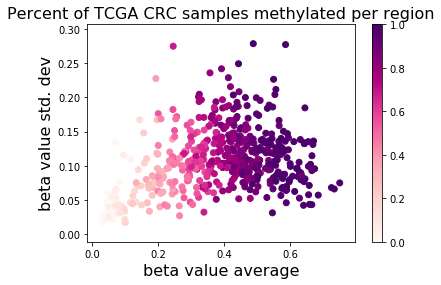

In [21]:
plt.figure()
plt.scatter(df_region_stats["sample_average_beta"], df_region_stats["mean_sample_stdv"],
           c=df_region_stats["pct_samples_meth"], cmap=matplotlib.cm.RdPu)

plt.colorbar()
plt.title("Percent of TCGA CRC samples methylated per region", size=16)
plt.ylabel("beta value std. dev", size=16)
plt.xlabel("beta value average", size=16)

plt.savefig(f"{regions}_PLOT.png")

In [ ]:
df_region_avs = pd.DataFrame(region_avs_list)
df_region_avs.index = region_names

df_region_avs = df_region_avs.fillna(0)
df_region_avs.head()

with open("./TCGA_auto_region_averages_for_heatmap.csv","w") as fout:
    df_region_avs.to_csv(fout)

In [10]:
with open("./TCGA_auto_region_averages_for_heatmap.csv","r") as fin:
    df_region_avs = pd.read_csv(fin)
    df_region_avs = df_region_avs.set_index("Unnamed: 0")
    
df_region_avs.head()



,TCGA-CI-6620-01A-11D-1828-05,TCGA-EI-6882-01A-11D-1926-05,TCGA-CI-6622-01A-11D-1828-05,TCGA-EI-6509-01A-11D-1734-05,TCGA-DY-A1H8-01A-21D-A153-05,TCGA-DC-5869-01A-01D-1658-05,TCGA-AF-2687-01A-02D-1734-05,TCGA-AF-4110-01A-02D-1734-05,TCGA-CI-6624-01C-11D-1828-05,TCGA-EI-6885-01A-11D-1926-05,...,TCGA-NH-A50T-01A-11D-A28O-05,TCGA-AZ-4308-01A-01D-1407-05,TCGA-D5-6535-01A-11D-1721-05,TCGA-T9-A92H-01A-11D-A36Y-05,TCGA-G4-6322-01A-11D-1721-05,TCGA-G4-6303-01A-11D-1772-05,TCGA-AZ-5407-01A-01D-1721-05,TCGA-A6-2677-01A-01D-A27A-05,TCGA-F4-6570-01A-11D-1772-05,TCGA-NH-A5IV-01A-42D-A36Y-05
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
chr1:4656231:4656664,0.500786,0.478458,0.489357,0.204624,0.630362,0.430564,0.077356,0.188684,0.069958,0.127494,...,0.454623,0.146639,0.325603,0.595465,0.394151,0.127060,0.522579,0.661450,0.551640,0.591001
chr1:9652044:9653147,0.465377,0.554365,0.457586,0.275252,0.403400,0.493338,0.277541,0.335116,0.275446,0.263852,...,0.579145,0.491924,0.454956,0.298286,0.496939,0.322684,0.542490,0.535968,0.507925,0.536977
chr1:12063201:12063806,0.364619,0.527262,0.458434,0.403756,0.457201,0.496680,0.157609,0.281077,0.172681,0.468066,...,0.434851,0.413049,0.489419,0.592927,0.421433,0.498893,0.536888,0.642411,0.490817,0.572654
chr1:13513048:13513402,0.566571,0.667528,0.591481,0.575427,0.754480,0.639997,0.140939,0.462707,0.302765,0.520565,...,0.588727,0.447682,0.577481,0.651051,0.056190,0.707213,0.608482,0.736324,0.567102,0.598827
chr1:14599268:14599580,0.530074,0.756740,0.603574,0.680992,0.769538,0.671563,0.244685,0.500289,0.536894,0.684520,...,0.775092,0.480513,0.630478,0.727430,0.682190,0.721187,0.651811,0.770094,0.700161,0.718307


<Figure size 432x288 with 0 Axes>

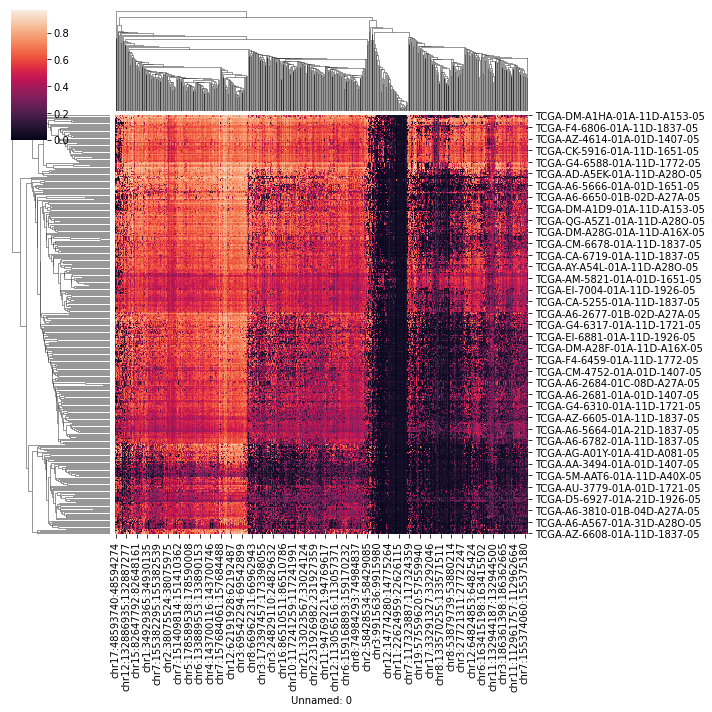

In [11]:
# get region order for the heatmap
plt.figure()
cm = sns.clustermap(df_region_avs.T)
#plt.ylabel("TCGA CRC Samples")
#plt.xlabel("auto regions")
#plt.savefig("./TCGA_Autoregions_clustermap.png")
tcga_col_order = np.array(df_region_avs.T.columns)[cm.dendrogram_col.reordered_ind]

154


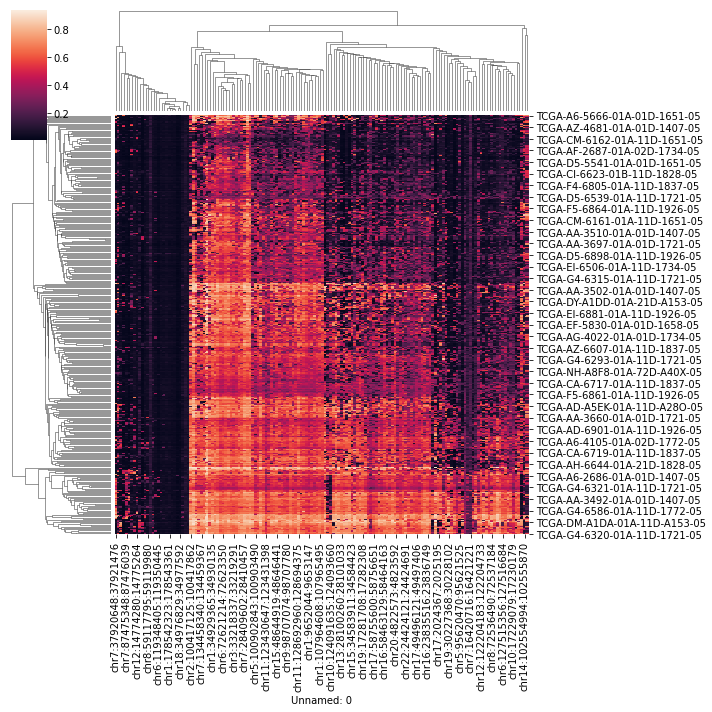

In [52]:
#filter for only modeling regions (154)
model_regions = [region_to_nused[reg]>0 for reg in df_region_avs.index]
print(sum(model_regions))
cm = sns.clustermap(df_region_avs.T.loc[:,model_regions])
col_order_modeling = np.array(df_region_avs.T.loc[:,model_regions].columns)[cm.dendrogram_col.reordered_ind]

# heatmap for inhouse samples

In [13]:
classes = ['colorectal_cancer_temseqV3_fuzzy_discovery2gamma_v1_nohightf_train',
'colorectal_cancer_temseqV3_fuzzy_discovery2gamma_v1_hightf_train',
'colorectal_cancer_temseqV3_fuzzy_discovery2beta_v2_nohightf_train',
'colorectal_cancer_temseqV3_fuzzy_discovery2beta_v2_hightf_train',
'colorectal_cancer_temseqV3_fuzzy_discovery2alpha_v5_nohightf_train',
'colorectal_cancer_temseqV3_fuzzy_discovery2alpha_v5_hightf_train']

class_labels = [1,1,1,1,1,1]
mat = mf.create_from_training_classes(classes,
                                    'hmcfc_methyl_v3_automatic_regions_20200407_with_top_teng/v1',
                                            class_labels)


In [14]:
mat.shape

(42, 626, 31, 2)

In [15]:
mat_region_names = [f"{d['seqname']}:{d['start']}:{d['end']}" for d in mat.column_metadata]

pct_methyl = pd.DataFrame(mat.x[:,:,0,0]/mat.x[:,:,0,1])

pct_methyl.columns = mat_region_names

pct_methyl = pct_methyl.T

pct_methyl.head()

len(set(df_region_avs.index).intersection(mat_region_names))

591

In [16]:
#remove regions without any tcga probes

reg_to_keep = [ reg in df_region_avs.index for reg in pct_methyl.index]
pct_methyl_f = pct_methyl[reg_to_keep]
pct_methyl_f.head()
print(pct_methyl_f.shape)
#print(col_order)
#print(pct_methyl_f.index)
#reorder columns as above heatment
pct_methyl_f_re = pct_methyl_f.loc[tcga_col_order,:]
#pct_methyl_f_re.head


(591, 42)


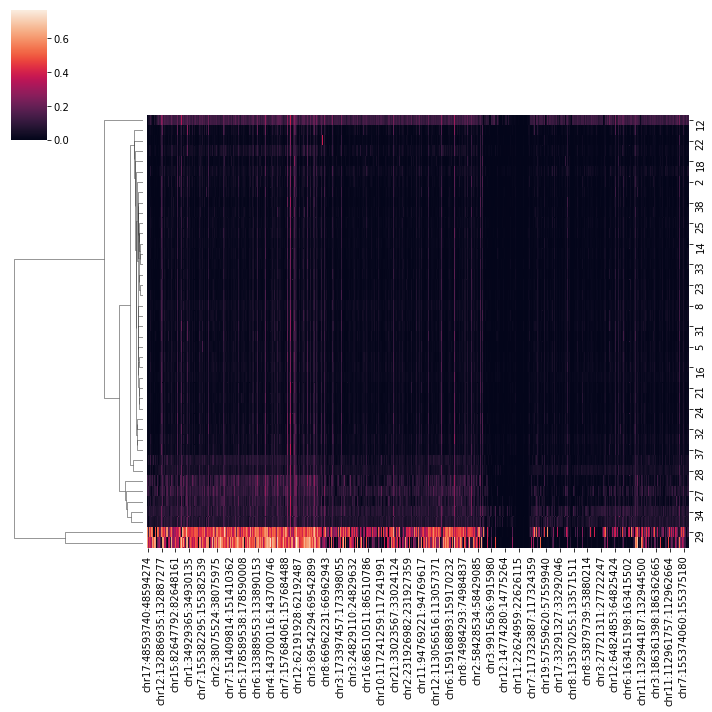

In [17]:
# clustermap all regions
sns.clustermap(pct_methyl_f_re.T,
              col_cluster=False)

#plt.savefig("./Autoregions_clustermap_DC2crc.png")

In [45]:
pct_methyl_f_re.index

Index(['chr17:48593740:48594274', 'chr4:153222678:153223311',
       'chr17:48047278:48047825', 'chr19:48739237:48739705',
       'chr20:58649959:58650320', 'chr17:77372786:77373324',
       'chr6:165660778:165661726', 'chr9:36258002:36258975',
       'chr11:829760:830331', 'chr11:57426818:57427177',
       ...
       'chr22:24424121:24424691', 'chr5:137498968:137499457',
       'chr5:10564338:10565185', 'chr17:49496121:49497406',
       'chr7:155374060:155375180', 'chr20:62550874:62551258',
       'chr17:73164680:73166280', 'chr7:90596478:90597276',
       'chr12:40224462:40225072', 'chr22:39153251:39153678'],
      dtype='object', length=591)

154


,chr7:37920648:37921476,chr7:99558520:99559257,chr2:136117523:136118336,chr8:22565914:22566304,chr7:87475348:87476039,chr9:19127137:19127882,chr1:226737656:226738004,chr11:133956529:133957272,chr12:14774280:14775264,chr6:118650435:118651972,...,chr6:127515356:127516684,chr1:219927772:219928736,chr19:1401179:1402054,chr1:101236161:101237444,chr10:17229079:17230179,chr3:27721311:27722247,chr6:88166725:88167674,chr19:57320175:57321045,chr14:102554994:102555870,chr9:36258002:36258975
0,0.001122,0.000000,0.005864,0.004942,0.004887,0.001290,0.000876,0.006536,0.002465,0.001285,...,0.004390,0.007368,0.031850,0.001850,0.004789,0.006459,0.012888,0.005546,0.107923,0.002250
1,0.003398,0.000000,0.005777,0.003870,0.010673,0.002308,0.000951,0.005259,0.002306,0.001724,...,0.007022,0.009577,0.029135,0.001653,0.013735,0.005195,0.009646,0.005277,0.132901,0.002889
2,0.001499,0.003648,0.000000,0.002280,0.005155,0.000472,0.000847,0.003468,0.003970,0.000288,...,0.003785,0.007757,0.019122,0.000523,0.002018,0.004230,0.007078,0.001929,0.120668,0.001962
3,0.004843,0.000000,0.003835,0.000818,0.005095,0.001397,0.000838,0.003858,0.004255,0.000542,...,0.013127,0.004871,0.024932,0.004607,0.028352,0.005202,0.012349,0.004822,0.105597,0.001394
4,0.001480,0.000000,0.001850,0.001563,0.006066,0.001171,0.041004,0.003289,0.001664,0.003966,...,0.023446,0.049505,0.023146,0.012237,0.052446,0.018071,0.021468,0.049153,0.130818,0.077974


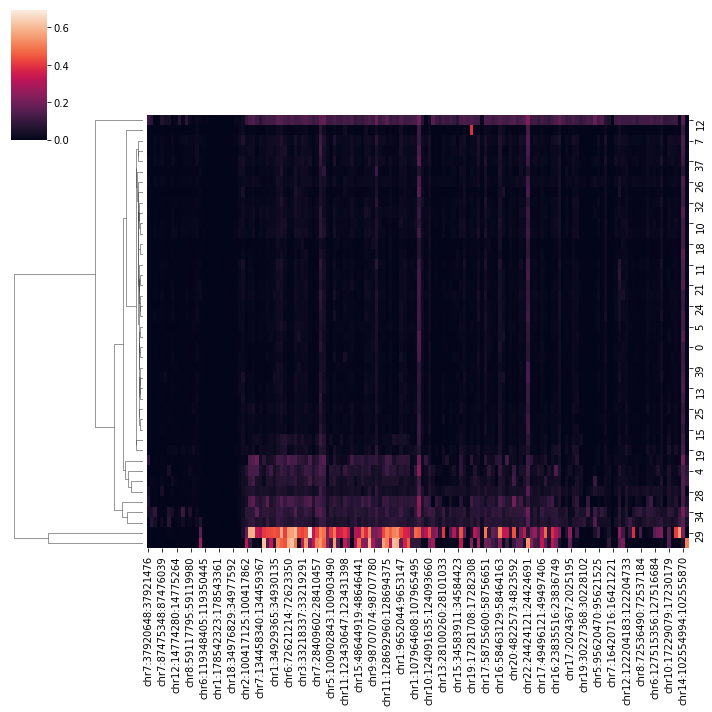

In [53]:
#Clustermap modeling regions in same col order as above

model_regions_bool = [region_to_nused[reg]>0 for reg in pct_methyl_f_re.index]
print(sum(model_regions_bool))

pct_methyl_model_regions = pct_methyl_f_re.T

pct_for_heatmap = pct_methyl_model_regions.loc[:,col_order_modeling]
#reorder as above
cm = sns.clustermap(pct_for_heatmap,
                   col_cluster=False)


pct_for_heatmap.head()

154

In [65]:
#rank the regions in inhouse data by # regions with any methylation

df_region_stats.head()

,pct_samples_meth,mean_sample_stdv,sample_average_beta,rank
chr1:4656231:4656664,0.808864,0.114837,0.402811,285.5
chr1:9652044:9653147,0.986150,0.249179,0.443114,519.0
chr1:12063201:12063806,0.919668,0.153153,0.447903,401.0
chr1:13513048:13513402,0.975069,0.185948,0.546534,488.0
chr1:14599268:14599580,0.994460,0.083995,0.622400,550.5


In [76]:
# rank the order of the regions
import scipy.stats as ss

#TCGA regions
region_ranks = ss.rankdata(df_region_stats["pct_samples_meth"], method='average')
df_region_stats["rank"] = region_ranks

# In house samples
#IH_rank_stat = pct_methyl_f_re.apply(lambda x: sum(x>0), axis=1)
IH_rank_stat = pct_methyl_f_re.mean(axis=1)
IH_rank = ss.rankdata(IH_rank_stat, method='average')
rank_dict = dict(zip(pct_methyl_f_re.index,IH_rank))
IH_rank_re = [rank_dict[reg] for reg in df_region_stats.index]

df_region_stats["IH_rank"] = IH_rank_re

Text(0, 0.5, 'TCGA rank')

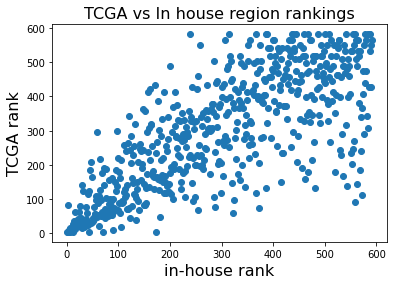

In [77]:
plt.figure()
plt.scatter(df_region_stats["IH_rank"], df_region_stats["rank"])
plt.title("TCGA vs In house region rankings", size=16)
plt.xlabel("in-house rank", size=16)
plt.ylabel("TCGA rank", size=16)

## RRBS data

In [14]:
classes = ["colorectal_cancer_tissuerrbs_dbgap",
           "colorectal_canceradjacentpolyp_tissuerrbs_dbgap",
           "colorectal_cancerfreepolyp_tissuerrbs_dbgap",
           "colorectal_healthy_tissuerrbs_dbgap",
           "peripheralbloodleukocytes_canceradjacentpolyp_tissuerrbs_dbgap",
           "peripheralbloodleukocytes_cancerfreepolyp_tissuerrbs_dbgap"]

labels = ["CRC","CAP","CFP","Healthy","PBL-CAP","PBL-CFP"]

mat_rrbs = mf.create_from_training_classes(classes,"hmcfc_methyl_v3_automatic_regions_20200407_with_top_teng/v1", labels)

mat_rrbs.shape

(87, 626, 31, 2)

In [16]:
mat_region_names = [f"{d['seqname'].strip()}:{d['start']}:{d['end']}" for d in mat_rrbs.column_metadata]

pct_methyl = pd.DataFrame(mat_rrbs.x[:,:,0,0]/mat_rrbs.x[:,:,0,1])

pct_methyl.columns = mat_region_names

pct_methyl.head()


,chr1:4656231:4656664,chr1:9652044:9653147,chr1:12063201:12063806,chr1:13513048:13513402,chr1:14599268:14599580,chr1:20553064:20553505,chr1:34163736:34164400,chr1:34929365:34930135,chr1:37034806:37035023,chr1:48776519:48777027,...,chr9:22446740:22447073,chr9:29214611:29215123,chr9:36258002:36258975,chr9:37026278:37027419,chr9:78296745:78297476,chr9:97852918:97853485,chr9:98707074:98707780,chr9:126723162:126723827,chr9:129620293:129620534,chr9:136199212:136199580
0,0.000000,0.424242,0.300000,0.0,0.187500,0.333333,0.600000,0.562500,0.538462,0.000000,...,0.000000,NaN,0.4000,0.400000,0.0,0.562500,0.227273,0.400000,0.600000,0.0
1,0.090909,0.322581,0.466667,1.0,0.400000,0.363636,0.352941,0.500000,0.625000,0.428571,...,0.083333,0.0,0.2000,0.500000,0.0,0.750000,0.200000,0.416667,0.583333,0.2
2,0.250000,0.192308,0.533333,0.0,0.363636,0.000000,0.352941,0.411765,0.454545,0.300000,...,0.000000,NaN,0.0625,0.291667,0.0,0.714286,0.120000,0.400000,0.666667,0.6
3,0.000000,0.034483,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.076923,0.000000,...,0.000000,0.0,0.0000,0.046512,0.0,0.000000,0.000000,0.000000,0.000000,0.0
4,0.000000,0.218750,0.266667,0.0,0.250000,0.142857,0.058824,0.090909,0.230769,0.153846,...,0.125000,0.5,0.0000,0.220000,0.0,0.230769,0.050000,0.230769,0.300000,0.2


In [17]:
#remove regions without any tcga probes
reg_to_keep = [ reg in df_region_avs.index for reg in pct_methyl.columns]
pct_methyl_f = pct_methyl.loc[:, reg_to_keep]
pct_methyl_f.head()


,chr1:4656231:4656664,chr1:9652044:9653147,chr1:12063201:12063806,chr1:13513048:13513402,chr1:14599268:14599580,chr1:20553064:20553505,chr1:34163736:34164400,chr1:34929365:34930135,chr1:37034806:37035023,chr1:48776519:48777027,...,chr9:17135048:17135759,chr9:19127137:19127882,chr9:36258002:36258975,chr9:37026278:37027419,chr9:78296745:78297476,chr9:97852918:97853485,chr9:98707074:98707780,chr9:126723162:126723827,chr9:129620293:129620534,chr9:136199212:136199580
0,0.000000,0.424242,0.300000,0.0,0.187500,0.333333,0.600000,0.562500,0.538462,0.000000,...,0.000000,0.0,0.4000,0.400000,0.0,0.562500,0.227273,0.400000,0.600000,0.0
1,0.090909,0.322581,0.466667,1.0,0.400000,0.363636,0.352941,0.500000,0.625000,0.428571,...,0.000000,0.0,0.2000,0.500000,0.0,0.750000,0.200000,0.416667,0.583333,0.2
2,0.250000,0.192308,0.533333,0.0,0.363636,0.000000,0.352941,0.411765,0.454545,0.300000,...,0.000000,0.0,0.0625,0.291667,0.0,0.714286,0.120000,0.400000,0.666667,0.6
3,0.000000,0.034483,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.076923,0.000000,...,0.000000,0.0,0.0000,0.046512,0.0,0.000000,0.000000,0.000000,0.000000,0.0
4,0.000000,0.218750,0.266667,0.0,0.250000,0.142857,0.058824,0.090909,0.230769,0.153846,...,0.176471,0.0,0.0000,0.220000,0.0,0.230769,0.050000,0.230769,0.300000,0.2


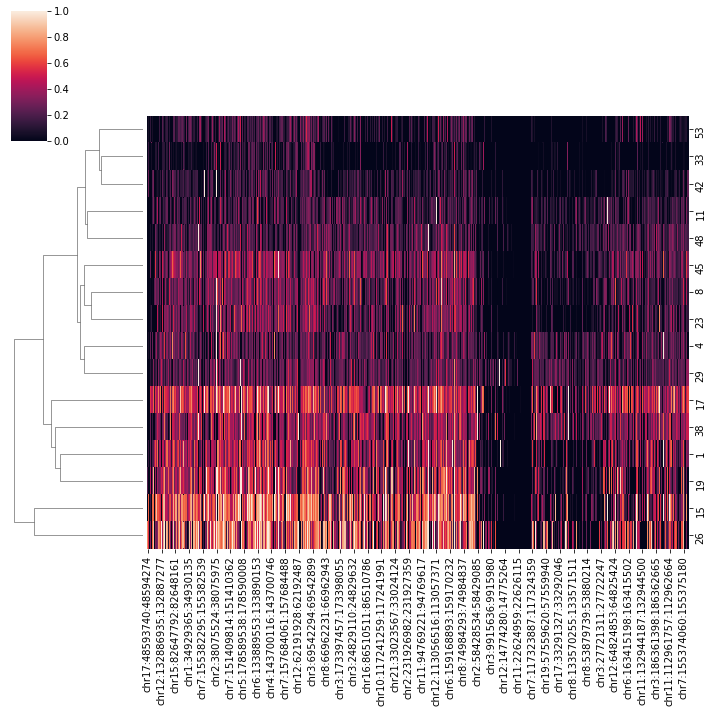

In [25]:
##CRC Tissues

#color_dict = {"CRC","CAP","CFP","Healthy","PBL-CAP","PBL-CFP"}

crcs = [y=="CRC" for y in mat_rrbs.y]
pct_methyl_crcs = pct_methyl_f[crcs]
pct_methyl_f_re_crcs = pct_methyl_crcs.loc[:, col_order]

pct_methyl_f_re_crcs.head()
pct_methyl_f_re_crcs = pct_methyl_f_re_crcs.fillna(0)

sns.clustermap(pct_methyl_f_re_crcs,
              col_cluster=False)

#plt.savefig("./Autoregions_clustermap_DC2crc.png")

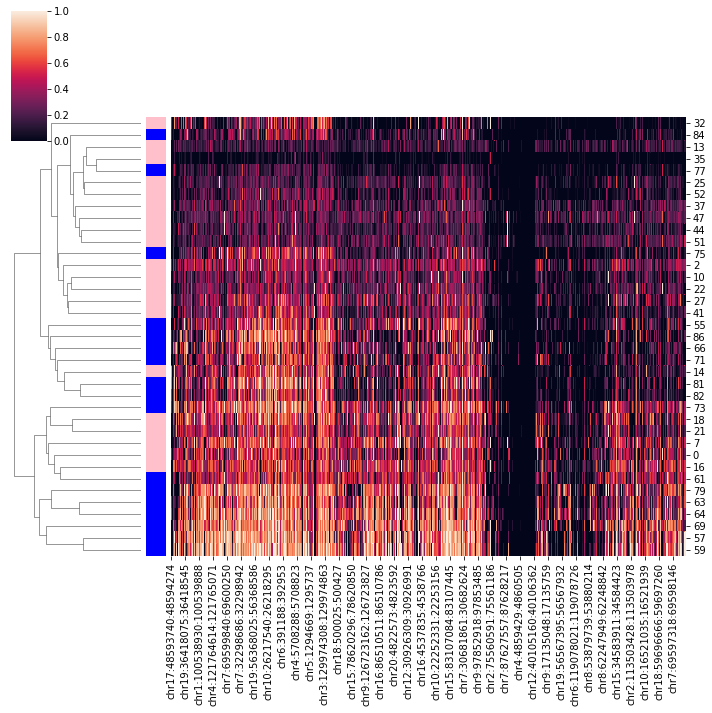

In [29]:
# AA Tissues
aas = [y=="CAP" or y=="CFP" for y in mat_rrbs.y]
pct_methyl_aas = pct_methyl_f[aas]
pct_methyl_f_re_aas = pct_methyl_aas.loc[:, col_order]

labels = mat_rrbs.y[aas]
colors = ["blue" if l =="CFP" else "pink" for l in labels]


pct_methyl_f_re_aas.head()
pct_methyl_f_re_aas = pct_methyl_f_re_aas.fillna(0)

sns.clustermap(pct_methyl_f_re_aas,
              col_cluster=False,
              row_colors=colors)
